# 6-channel transfer-learning

In [1]:
%%capture

from __future__ import print_function, division
from dataclasses import dataclass, replace
from pathlib import Path
from typing import Callable, List, Optional, Sequence, Union

import pandas as pd
import torch 
import os
from pandas import DataFrame
from PIL import Image
from torch.utils.data.dataloader import default_collate
import sklearn
import numpy as np
from matplotlib import pyplot as plt

import numpy as np
from torchvision import transforms

from torchvision import models
from torch.nn.modules import loss
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torchvision.transforms.functional as TF
from tqdm.auto import tqdm

import os
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
from torchvision.transforms import RandomVerticalFlip, RandomCrop

from albumentations import RandomCrop, Normalize, HorizontalFlip, Resize
from albumentations import Compose
from albumentations.pytorch import ToTensor

import datetime


In [2]:
!pip uninstall -y enum34
!pip install wandb

In [4]:
import wandb
wandb.init(project="kern", name='rn18-1e-5-3-3')


W&B Run: https://app.wandb.ai/nuvard/kern/runs/k1gc6tth

In [5]:
DEVICE = torch.device("cuda")

In [6]:
import sys
sys.path.append('../src/')
sys.path.append('..')

import src.utils as my_utils
from train import *
from dataset import *

In [5]:
def test(device: str):
    torch.ones(1,2,3).to(device)

test(DEVICE)

In [7]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.cuda.manual_seed(42)

torch.backends.cudnn.enabled = False 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [7]:
set_seed()

In [8]:
!ls ../data

Unload1  Unload2  data	data.csv  data_dc.csv  data_uf.csv


In [8]:
IMAGE_SIZE = 128
BATCH_SIZE = 64
PATH = '/project/data/'
LOG_PATH = '/project/'
NUM_CLASSES = 6
LR = 1e-5

In [13]:
!python /project/src/train.py --name "rn-18-ft-1e-5-drop"


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [10]:
def apply_class(data, column, class_dict):
    data['class']=data[column].apply(lambda x:class_dict[x] if (x in class_dict) else x) 
    
    
def check(data):
    to_drop = []
    for i in data.index:
        img_name=data.loc[i, 'Folder']+'/data/'+str(data.loc[i, 'Id'])+'.jpeg'
        #print(PATH+img_name)
        #plt.figure()
        
        if not os.path.isfile(os.path.join(PATH, img_name)):
            to_drop.append(i)
            print("No image " + img_name)
        #plt.show()
    if(len(to_drop)==0):
        print ("All is OK!")

    return data.loc[~data.index.isin(to_drop),]  

def pil2tensor(image1, image2):
    "Convert PIL style `image` array to torch style image tensor."
    print('pil2tensor')
    image2 = image2.resize(image1.size)
    a = torch.from_numpy(np.asarray(image1))
    b = torch.from_numpy(np.asarray(image2))
    concated = torch.cat((a,b),-1)
    return concated


Transform = Callable[[Image.Image], Image.Image]

def show_batch_image(image_batch, batch_size=4, name='out.png', a = 0, b = 3 ):
    """
    Show a sample grid image which contains some sample of test set result
    :param image_batch: The output batch of test set
    :param a: - first channel to draw
    :param b: - (b-1) is last channel to draw
    :return: PIL image of all images of the input batch
    """
    print('show!')
    #inv_normalize = transforms.Normalize(
    #mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    #std=[1/0.229, 1/0.224, 1/0.255])
    
    to_pil =  transforms.ToPILImage()
    fs = []
    for i in range(batch_size):
        img = to_pil(image_batch.images[i,a:b,:,:].cpu())
        fs.append(img)
    x, y = fs[0].size
    ncol = int(np.ceil(np.sqrt(batch_size)))
    nrow = int(np.ceil(np.sqrt(batch_size)))
    cvs = Image.new('RGB', (x * ncol, y * nrow))
    for i in range(len(fs)):
        px, py = x * int(i / nrow), y * (i % nrow)
        cvs.paste((fs[i]), (px, py))
    #print(name)
    cvs.save(name, format='png')
    #cvs.show()
    plt.imshow(np.asarray(cvs))

    

@dataclass()
class ItemsBatch:
    images: torch.Tensor
    labels: torch.Tensor
    ids: List[int]
    paths: List[Path]
    items: List["DatasetItem"]


@dataclass()
class DatasetItem:
    image: Union[torch.Tensor, Image.Image]
    label: int
    id: int
    path: Path

    @classmethod
    def collate(cls, items: Sequence["DatasetItem"]) -> ItemsBatch:
        if not isinstance(items, list):
            items = list(items)
            #print(default_collate([item.label for item in items]))
        return ItemsBatch(
            images=default_collate([item.image for item in items]),
            
            labels=default_collate([item.label for item in items]),
            ids=[item.id for item in items],
            paths=[item.path for item in items],
            items=items,
        )


## Подготовка данных

### Загрузка таблиц

In [11]:
data_uf = pd.read_csv(PATH+'data_uf.csv', index_col=0)
data_dc = pd.read_csv(PATH+'data_dc.csv', index_col=0)

In [12]:
temp = check(data_uf)

All is OK!


### Переопределение классов

Нам нужны не все классы, а только некоторые. Пока я подготовлю словари для переименования классов. 

In [16]:
satur_dict = {'не опред.': 0, 'нефтенасыщенные': 1,'битуминозный':2, 'продукт':3, 'пятнисто нефтенасыщенные': 4,'слабо нефтенасыщенные':5 }

In [0]:
satur_int_dict = {'oil':0, 'unknown':1}

In [0]:
rock_dict = {"с карбонатными обломками или конкрециями": "с карб. обломками или конкрециями", \
             "пересл. кремнисто-глинистой породы и аргиллита": "пересл. кремн.-глинист. породы и аргиллитa", \
             "пересл. песчаника и глины аргиллитоподобной" : "пересл. песчаника и глины аргиллитоподобн."}

In [0]:
carbon_dict = {"не карбонатный": 'no_carbon', 'с карбонатными обломками или конкрециями': 'part_carbon', 'слабокарбонатный': 'carbon', \
               'сильнокарбонатный': 'carbon', 'среднекарбонатный':'carbon', 'пятнисто карбонатный':'part_carbon', 'с примесью':'part_carbon'}

In [0]:
ruin_dict = {"не карбонатный": 'no_carbon', 'с карбонатными обломками или конкрециями': 'part_carbon', 'слабокарбонатный': 'carbon', \
               'сильнокарбонатный': 'carbon', 'среднекарбонатный':'carbon', 'пятнисто карбонатный':'part_carbon', 'с примесью':'part_carbon'}

In [0]:
apply_class(data,'Saturation', satur_dict)

In [17]:
apply_class(data_uf,'Saturation', satur_dict)
apply_class(data_dc,'Saturation', satur_dict)

In [20]:
data_dc.to_csv(PATH+'data_dc.csv')

## Создание датасета

2 статьи на хабре: от[ snakers4](https://habr.com/ru/post/349068/) и [ternaus](https://habr.com/ru/company/ods/blog/330118/).

Гитхаб: [snakers4](https://github.com/snakers4/spacenet-three), [pretrained resnet with fast.ai for proteins](https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb)


In [21]:
class KernDataset(Dataset):
    """Kern dataset."""

    def __init__(self, csv_file_dc,csv_file_uf, root_dir, transform=None, acc=0.2):
        np.random.seed(42)
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.acc = acc
        self.data_uf = pd.read_csv(csv_file_uf)
        self.labels_path = csv_file_uf
        self.root_dir = root_dir
        self.transform = transform
        self.data_dc = pd.read_csv(csv_file_dc)
    
    def __len__(self):
        return len(self.data_uf)

    def __getitem__(self, idx):
        #print('idx '+str(idx))
        dc_img_name = os.path.join(self.root_dir,
                                self.data_dc.loc[idx, 'Folder']+'/data/'+str(self.data_dc.loc[idx, 'Id'])+'.jpeg')
        
        uf_img_name = os.path.join(self.root_dir,
                                self.data_uf.loc[idx, 'Folder']+'/data/'+str(self.data_uf.loc[idx, 'Id'])+'.jpeg')
        
        layer_width = self.data_dc.loc[idx, "LayerDown"] - self.data_dc.loc[idx, "LayerTop"]
        image_dc = Image.open(dc_img_name)
        image_uf = Image.open(uf_img_name).resize(image_dc.size)
        
        crop_size = min(image_dc.size[1], int(image_dc.size[1]*(self.acc/layer_width))-1)
        
        image_np = np.concatenate((np.array(image_dc),np.array(image_uf)), axis=-1)
        
        transf = RandomCrop( crop_size,image_dc.size[0] )
        image_np = transf(image=image_np)['image']
        
        if (crop_size<IMAGE_SIZE):
            transf = Resize(IMAGE_SIZE, int(image_dc.size[0]*(IMAGE_SIZE/crop_size)+1))
            image_np = transf(image=image_np)['image']
        if (transform is not None):
            augmented = self.transform(image = image_np)['image']
            augmented = torch.from_numpy(np.moveaxis(augmented / (255.0 if augmented.dtype == np.uint8 else 1), -1, 0).astype(np.float32))
            
        label = self.data_dc.loc[idx, 'class']
        #print(label)
        #sample = {'image': image, 'class_name': label}
        return DatasetItem(image=augmented, label=label, id=idx, path=dc_img_name)

Делю датасет на трейн и тест

In [22]:
validation_split = .2
shuffle_dataset = True
random_seed = 42

dataset_size = len(data_uf)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


In [23]:
"""

transform = transforms.Compose(
    [
        #transforms.RandomRotation((5)),
        transforms.RandomResizedCrop((128,128)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]
)

"""

def strong_aug(p=0.5):
    return Compose(
      [ RandomCrop(IMAGE_SIZE, IMAGE_SIZE, p=1),
        HorizontalFlip(p=p),
        #Normalize([0.4802, 0.4481, 0.3975, 0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262,0.2302, 0.2265, 0.2262])
      ], 
    )

transform = strong_aug(p=0.5)


dataset = KernDataset(csv_file_uf=PATH+'data_uf.csv',csv_file_dc=PATH+'data_dc.csv',
                                    root_dir=PATH, transform = strong_aug(p=0.5))

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
#train_dataset_dc, test_dataset_dc = torch.utils.data.random_split(dataset_dc, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=DatasetItem.collate,
    num_workers=4,
    worker_init_fn=set_seed()
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    collate_fn=DatasetItem.collate,
    num_workers=4,
    worker_init_fn=set_seed()
)


In [24]:
temp = next(iter(train_loader))

show!


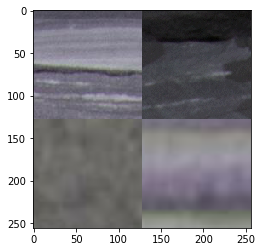

In [25]:
show_batch_image(temp, a=0, b=3)
    

show!


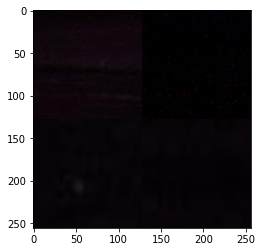

In [26]:
show_batch_image(temp,a = 3,b = 6)


## Обучение модели 


In [27]:
from tqdm import tqdm_notebook

In [28]:
wandb.config.input_size = 224
wandb.config.output_size = 6
wandb.config.name = 'resnet50_all_metrics_1e-5'
wandb.config.lr = LR


In [36]:

def save_files_to_wandb(name):
    if not os.path.isdir(os.path.join(wandb.run.dir, 'trained_models')):
        os.mkdir(os.path.join(wandb.run.dir, 'trained_models'))
    files_to_copy = ['trained_models/'+name+'.pth']
    for fname in files_to_copy:
        dest_path = os.path.join(wandb.run.dir, fname)
        if os.path.isdir(fname):
            shutil.copytree(fname, dest_path)
        else:
            shutil.copy2(fname, dest_path)       
            
def log_wandb_images(inputs, labels, output, idx):

    inps_cpu = inputs[0][0:3,:,:].detach().cpu().numpy()
    x_image = Image.fromarray(np.uint8(np.round((x + 0.5)*255)))
    input_images.append(wandb.Image(x_image))
    
    wandb.log({"examples": payload}, commit=False)
    

           

In [30]:
import shutil

In [37]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score
def to_numpy(target):
    return target.detach().cpu().numpy()

def train(model, device, train_loader, optimizer, loss_function, epoch, name = 'resnet-18-finetune'):
    model.train()
    model.to(device)
    correct = 0
    best_f1 = 0
    best_loss_so_far = 10
    running_loss = 0
    for idx, batch_data in enumerate(tqdm(train_loader)):
        data, target = batch_data.images.to(device), batch_data.labels.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        if (idx==0):
            preds=pred.flatten()
            outputs = output
            targets=target
        else:
            preds = torch.cat((preds, pred.flatten()),0)
            targets = torch.cat((targets, target),0)
            outputs = torch.cat((outputs, output),0)
        running_loss += loss.sum().item()   
        correct += pred.eq(target.view_as(pred)).sum().item()
    running_loss = running_loss/len(train_loader.dataset)
    f1 = f1_score(to_numpy(preds), to_numpy(targets), average="macro") 
    roc = roc_auc_score(y_score = to_numpy(torch.softmax(outputs, dim=1)), \
                            y_true = to_numpy(torch.nn.functional.one_hot(targets, NUM_CLASSES)), \
                           average = 'macro')
    ap = precision_score(to_numpy(preds), to_numpy(targets), average="macro")
    
    wandb.log({'Train loss': running_loss, 'F1': f1, "ROC-AUC": roc,\
               'AP': ap}, step=epoch)
   
    print(
        "Train Epoch: {} \tLoss: {:.6f}    F1: {:.4f}    ROC-AUC: {:.4f}".format(
            epoch, running_loss, f1, roc
        )
    )
    
    if running_loss < best_loss_so_far:
        best_loss_so_far = loss
        wandb.run.summary['Best train loss'] = loss
        wandb.run.summary['Best epoch'] = epoch
        wandb.save(os.path.join(wandb.run.dir, name+'.h5'))
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, "trained_models/" + name +".pth")
    

                
    
def test(model, device, test_loader, loss_function, epoch):
    model.eval()
    model.to(device)
    test_loss = 0
    correct = 0
    example_images = []
    with torch.no_grad():
        for idx, batch_data in enumerate(tqdm(test_loader)):
            aug_outputs = []
            for i in range(3):
                data, target = batch_data.images.to(device), batch_data.labels.to(device)
                aug_outputs.append(model(data))
            output = torch.stack(aug_outputs)
            output = torch.mean(output, dim=0) 
            test_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            if (idx==0):
                preds=pred.flatten()
                targets=target
                outputs=output
            else:
                preds = torch.cat((preds, pred.flatten()),0)
                targets = torch.cat((targets, target),0)
                outputs = torch.cat((outputs, output),0)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    
    f1 = f1_score(to_numpy(preds), to_numpy(targets), average="macro") 
    roc = roc_auc_score(y_score = to_numpy(torch.softmax(outputs, dim=1)), \
                            y_true = to_numpy(torch.nn.functional.one_hot(targets, NUM_CLASSES)), \
                           average = 'macro')
    ap = precision_score(to_numpy(preds), to_numpy(targets), average="macro")
    
    wandb.log({'Test loss': test_loss, 'Test F1': f1,  "Test ROC-AUC": roc,\
             'Test AP': ap}, step=epoch)
    print(
        "\nTest set: Average loss: {:.4f}, F1: {:.4f}\n".format(
            test_loss,
            f1
        )
    )

In [32]:
len(data_uf['class'].value_counts())

6

Пока я создаю базовые модельки. 
Я постараюсь делать всё по гайду https://karpathy.github.io/2019/04/25/recipe/.

In [33]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 6)
#print(model)
temp = model.conv1.weight
model.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.conv1.weight = nn.Parameter(torch.cat((temp,temp),dim=1))
print(model.conv1.weight.size())
#torch.nn.init.xavier_uniform_(model_dc.fc.bias)
#with torch.no_grad():
#  model_dc.fc.bias = nn.Parameter(torch.Tensor([0.5, 0.5]))
 
model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

loss_function = loss.CrossEntropyLoss()

torch.Size([64, 6, 7, 7])


In [34]:
#Предварительный тест до обучения
test(model, DEVICE, test_loader, loss_function,0)



Test set: Average loss: 0.0319, F1: 0.0895



table = wandb.Table(columns=["Text", "Predicted Label", "True Label"])})
table.add_data("I love my phone", "1", "1")
table.add_data("My phone sucks", "0", "-1")
wandb.log({"examples": table})

In [ ]:
for epoch in range(1000):
    NAME = 'r18-ft-5-2'
    train(model, DEVICE, train_loader, optimizer, loss_function, epoch, name = NAME)
    save_files_to_wandb(NAME) 
    wandb.config.update({
    "name": NAME,
    "type": 'fine-tune',
    "epochs" : epoch,
    "batch_size" : BATCH_SIZE,
    "img_dim" : IMAGE_SIZE,
    "num_classes" : NUM_CLASSES,
    "n_train" : len(train_dataset),
    "n_valid" : len(test_dataset),
    "fc_size" : 512,
    "lr" : LR,
    "mnt" : 0,
    "base_model" : 'resnet18' 
        }, allow_val_change=True)
    test(model, DEVICE, test_loader, loss_function, epoch)

wandb: WARNING Adding to old History rows isn't currently supported.  Step 0 < 1; dropping {'Train loss': 0.019721368902143214, 'F1': 0.311775051330032, 'ROC-AUC': 0.7674293781843863, 'AP': 0.33549746011534404}.



Train Epoch: 0 	Loss: 0.019721    F1: 0.3118    ROC-AUC: 0.7674


wandb: WARNING Adding to old History rows isn't currently supported.  Step 0 < 1; dropping {'Test loss': 0.018285502154507742, 'Test F1': 0.38563770536037595, 'Test ROC-AUC': 0.7930946537609964, 'Test AP': 0.3819176082927893}.




Test set: Average loss: 0.0183, F1: 0.3856




Train Epoch: 1 	Loss: 0.014758    F1: 0.3710    ROC-AUC: 0.8162




Test set: Average loss: 0.0139, F1: 0.4137




Train Epoch: 2 	Loss: 0.013251    F1: 0.4108    ROC-AUC: 0.8626




Test set: Average loss: 0.0132, F1: 0.4797




Train Epoch: 3 	Loss: 0.011450    F1: 0.4869    ROC-AUC: 0.8732




Test set: Average loss: 0.0123, F1: 0.5106




Train Epoch: 4 	Loss: 0.010488    F1: 0.5191    ROC-AUC: 0.8979




Test set: Average loss: 0.0113, F1: 0.5643




Train Epoch: 5 	Loss: 0.010230    F1: 0.5274    ROC-AUC: 0.8898




Test set: Average loss: 0.0094, F1: 0.5908




Train Epoch: 6 	Loss: 0.009757    F1: 0.5172    ROC-AUC: 0.9014




Test set: Average loss: 0.0097, F1: 0.5836




Train Epoch: 7 	Loss: 0.009277    F1: 0.5505    ROC-AUC: 0.9130




Test set: Average loss: 0.0094, F1: 0.5672




Train Epoch: 8 	Loss: 0.009118    F1: 0.5810    ROC-AUC: 0.9147




Test set: Average loss: 0.0094, F1: 0.5955




Train Epoch: 9 	Loss: 0.008854    F1: 0.5623    ROC-AUC: 0.9205




Test set: Average loss: 0.0092, F1: 0.5707




Train Epoch: 10 	Loss: 0.008466    F1: 0.5910    ROC-AUC: 0.9210




Test set: Average loss: 0.0092, F1: 0.5648




Train Epoch: 11 	Loss: 0.008544    F1: 0.5872    ROC-AUC: 0.9150




Test set: Average loss: 0.0106, F1: 0.6112




Train Epoch: 12 	Loss: 0.008104    F1: 0.5992    ROC-AUC: 0.9246




Test set: Average loss: 0.0081, F1: 0.6193




Train Epoch: 13 	Loss: 0.008267    F1: 0.5783    ROC-AUC: 0.9279




Test set: Average loss: 0.0081, F1: 0.6037




Train Epoch: 14 	Loss: 0.008122    F1: 0.5942    ROC-AUC: 0.9308




Test set: Average loss: 0.0083, F1: 0.6147




Train Epoch: 15 	Loss: 0.007783    F1: 0.6122    ROC-AUC: 0.9350




Test set: Average loss: 0.0089, F1: 0.6515




Train Epoch: 16 	Loss: 0.007968    F1: 0.6106    ROC-AUC: 0.9186




Test set: Average loss: 0.0087, F1: 0.6178




Train Epoch: 17 	Loss: 0.007544    F1: 0.6212    ROC-AUC: 0.9332




Test set: Average loss: 0.0079, F1: 0.6382




Train Epoch: 18 	Loss: 0.007472    F1: 0.6092    ROC-AUC: 0.9345




Test set: Average loss: 0.0081, F1: 0.6343




Train Epoch: 19 	Loss: 0.007413    F1: 0.6461    ROC-AUC: 0.9403




Test set: Average loss: 0.0079, F1: 0.6048




Train Epoch: 20 	Loss: 0.007442    F1: 0.6251    ROC-AUC: 0.9367




Test set: Average loss: 0.0084, F1: 0.5784




Train Epoch: 21 	Loss: 0.007498    F1: 0.6408    ROC-AUC: 0.9410




Test set: Average loss: 0.0074, F1: 0.5978




Train Epoch: 22 	Loss: 0.007347    F1: 0.6401    ROC-AUC: 0.9382




Test set: Average loss: 0.0102, F1: 0.6051




Train Epoch: 23 	Loss: 0.007325    F1: 0.6266    ROC-AUC: 0.9444




Test set: Average loss: 0.0092, F1: 0.5954




Train Epoch: 24 	Loss: 0.007340    F1: 0.6119    ROC-AUC: 0.9438




Test set: Average loss: 0.0077, F1: 0.6291




Train Epoch: 25 	Loss: 0.006748    F1: 0.6529    ROC-AUC: 0.9469




Test set: Average loss: 0.0089, F1: 0.6492




Train Epoch: 26 	Loss: 0.007014    F1: 0.6433    ROC-AUC: 0.9461




Test set: Average loss: 0.0074, F1: 0.6380





Test set: Average loss: 0.0070, F1: 0.6137




Train Epoch: 28 	Loss: 0.006471    F1: 0.6760    ROC-AUC: 0.9507




Test set: Average loss: 0.0073, F1: 0.6048




Train Epoch: 29 	Loss: 0.007127    F1: 0.6774    ROC-AUC: 0.9508




Test set: Average loss: 0.0080, F1: 0.6717




Train Epoch: 30 	Loss: 0.006480    F1: 0.6656    ROC-AUC: 0.9502




Test set: Average loss: 0.0085, F1: 0.6336




Train Epoch: 31 	Loss: 0.006806    F1: 0.6747    ROC-AUC: 0.9461




Test set: Average loss: 0.0069, F1: 0.6608

